In [1]:
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import random as python_random

import pickle
import pandas as pd
import numpy as np
import glob

# Load data

In [2]:
df_all = pd.read_csv('../train_val_test_split/train_val_test_GoogleAudioSet.csv', index_col=0)

embedding_raw_matrix = np.load('../data/processed/20230304/embedding_raw_matrix.npy')
embedding_bg_matrix = np.load('../data/processed/20230304/embedding_bg_matrix.npy')
embedding_fg_matrix = np.load('../data/processed/20230304/embedding_fg_matrix.npy')

vgg_raw_matrix = np.load('../data/processed/20230304/vgg_raw_matrix.npy')
vgg_bg_matrix = np.load('../data/processed/20230304/vgg_bg_matrix.npy')
vgg_fg_matrix = np.load('../data/processed/20230304/vgg_fg_matrix.npy')

mps_raw_matrix = np.load('../data/processed/20230304/mps_raw_matrix.npy')
mps_bg_matrix = np.load('../data/processed/20230304/mps_bg_matrix.npy')
mps_fg_matrix = np.load('../data/processed/20230304/mps_fg_matrix.npy')

df_indices_raw = pd.read_csv('../data/processed/20230304/df_indices_raw.csv', index_col=0)
df_indices_bg = pd.read_csv('../data/processed/20230304/df_indices_bg.csv', index_col=0)
df_indices_fg = pd.read_csv('../data/processed/20230304/df_indices_fg.csv', index_col=0)

panns_clip_raw = np.load('../data/processed/20230304/panns_clip_raw.npy')
panns_clip_bg = np.load('../data/processed/20230304/panns_clip_bg.npy')
panns_clip_fg = np.load('../data/processed/20230304/panns_clip_fg.npy')
panns_embedding_raw = np.load('../data/processed/20230304/panns_embedding_raw.npy')
panns_embedding_bg = np.load('../data/processed/20230304/panns_embedding_bg.npy')
panns_embedding_fg = np.load('../data/processed/20230304/panns_embedding_fg.npy')

In [3]:
ind_city = df_all['category'] == 1
ind_nature = df_all['category'] == 0

# T-test of "city vs. nature": soundscape indices

In [4]:
from scipy.stats import ttest_ind

statistic_all, pvalue_all = ttest_ind(df_indices_raw[ind_nature], df_indices_raw[ind_city], nan_policy='omit', equal_var=False)
statistic_bg, pvalue_bg = ttest_ind(df_indices_bg[ind_nature], df_indices_bg[ind_city], nan_policy='omit', equal_var=False)
statistic_fg, pvalue_fg = ttest_ind(df_indices_fg[ind_nature], df_indices_fg[ind_city], nan_policy='omit', equal_var=False)

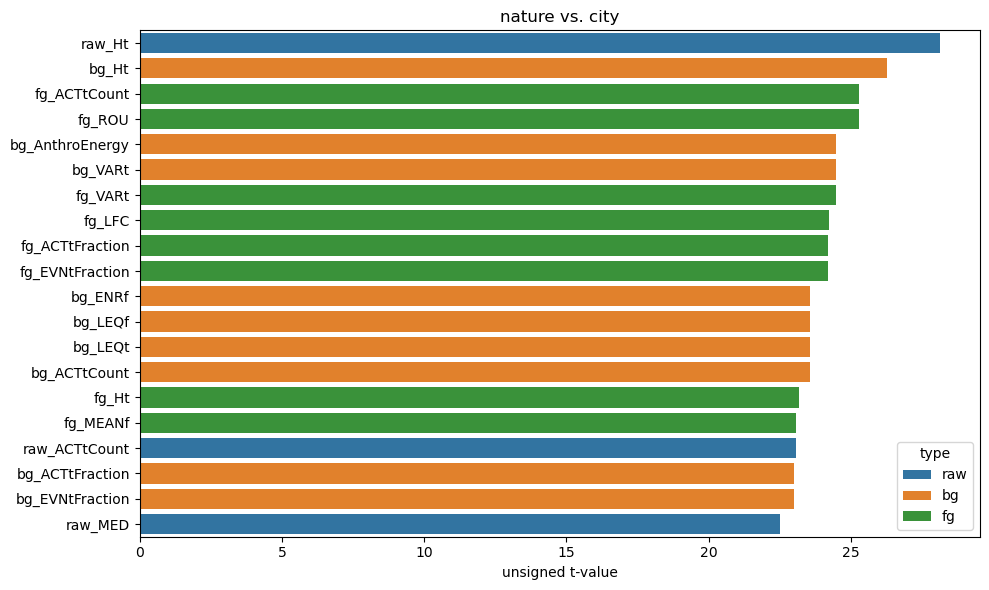

In [5]:
tval_df = pd.DataFrame(index = ('raw_'+df_indices_raw.columns).append('bg_'+df_indices_bg.columns).append('fg_'+df_indices_fg.columns), 
                       data = np.abs(list(statistic_all.data)+list(statistic_bg.data)+list(statistic_fg.data)),
                       columns = ['stats'])
tval_df['type'] = [i.split('_', 1)[0] for i in tval_df.index]

tval_df.sort_values(by=['stats'], ascending=False, inplace = True)
sel_range = 20
tval_df = tval_df.iloc[:sel_range]

fig, ax = plt.subplots(figsize=(10,6)) 

graph = sns.barplot(y=list(tval_df.index), x=tval_df['stats'], ax=ax, orient = 'h', hue=tval_df['type'], dodge = False)
ax.set_xlabel('unsigned t-value')
plt.title('nature vs. city')
plt.tight_layout()
plt.show()

Of the top 20 indices with the largest unsigned t-values, 9 were based on background (bg) signal, 8 were based on foreground signal, and 3 were based on raw signal (the mixture of bg and fg). Moreover, the indices that showed the greatest differences between urban and natural categories varied across signals. This suggests that the separation of bg and fg signals is effective and that both types of signal contain valuable information for classification.

# Correlations among indices

Using linear correlation to inspect whether there are any associations among the indices.

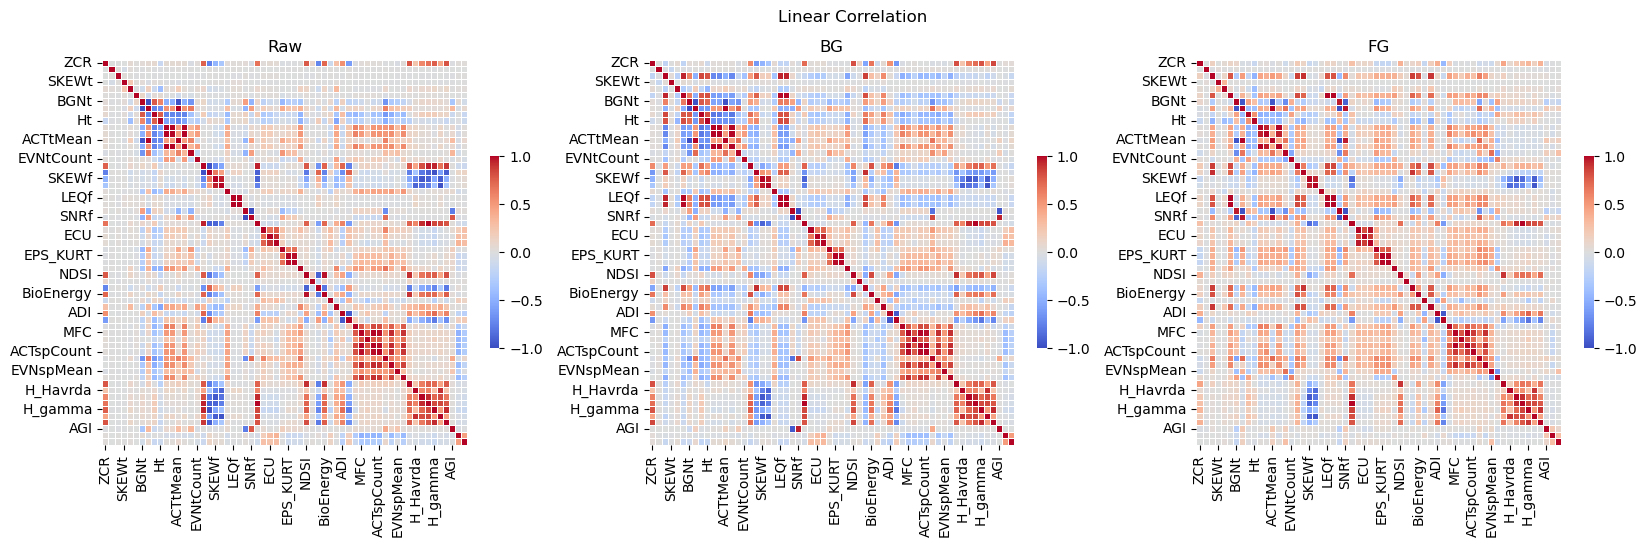

In [6]:
fig, (ax1, ax2, ax3)  = plt.subplots(ncols=3, figsize=(20,5)) 
sns.heatmap(df_indices_raw.corr(), linewidth = 0.5 , cmap = 'coolwarm', vmin=-1, vmax=1, ax = ax1, cbar_kws={"shrink": 0.5})
sns.heatmap(df_indices_bg.corr(), linewidth = 0.5 , cmap = 'coolwarm', vmin=-1, vmax=1, ax = ax2, cbar_kws={"shrink": 0.5})
sns.heatmap(df_indices_fg.corr(), linewidth = 0.5 , cmap = 'coolwarm', vmin=-1, vmax=1, ax = ax3, cbar_kws={"shrink": 0.5})
ax1.title.set_text('Raw')
ax2.title.set_text('BG')
ax3.title.set_text('FG')
plt.suptitle('Linear Correlation')
plt.show()

Obviously, some indices have high correlations. Therefore, the dimensionality of the soundscape indices' data can be significantly reduced before applying deep learning.

# T-test of "city vs. nature": spectrotemporal modulation power

In [7]:
statistic_all, pvalue_all = ttest_ind(mps_raw_matrix[ind_nature,:], mps_raw_matrix[ind_city,:], nan_policy='omit', equal_var=False, axis=0)
statistic_bg, pvalue_bg = ttest_ind(mps_bg_matrix[ind_nature,:], mps_bg_matrix[ind_city,:], nan_policy='omit', equal_var=False, axis=0)
statistic_fg, pvalue_fg = ttest_ind(mps_fg_matrix[ind_nature,:], mps_fg_matrix[ind_city,:], nan_policy='omit', equal_var=False, axis=0)

# reshape back to 2D
statistic_all_reshape = statistic_all.reshape(77,101)
statistic_bg_reshape = statistic_bg.reshape(77,101)
statistic_fg_reshape = statistic_fg.reshape(77,101)

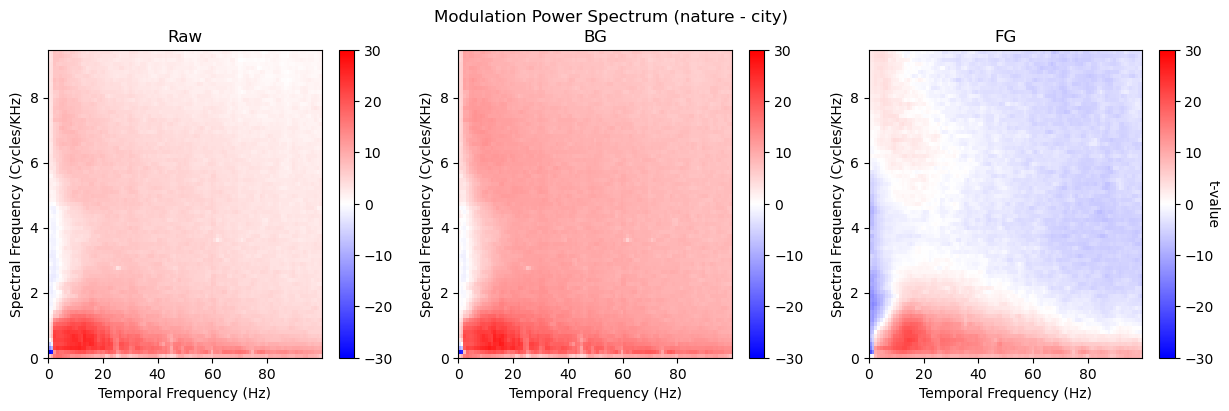

In [8]:
# getting the axis from one file
import pickle
file = open(df_all.loc[0,'file'], 'rb')
output = pickle.load(file)
wt_ind = output['wt']<=100
wt = output['wt'][output['wt']<=100]
wf = output['wf']
file.close()

# plot
fig, (ax1, ax2, ax3)  = plt.subplots(ncols=3, figsize=(15,4)) 
cmap = plt.get_cmap('bwr')
ex = (wt.min(), wt.max(), wf.min()*1e3, wf.max()*1e3)
scale_max = 30
img1 = ax1.imshow(statistic_all_reshape, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex, 
          vmin = -scale_max, vmax = scale_max)
ax1.set_ylabel('Spectral Frequency (Cycles/KHz)')
ax1.set_xlabel('Temporal Frequency (Hz)')
img2 = ax2.imshow(statistic_bg_reshape, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex, 
          vmin = -scale_max, vmax = scale_max)
ax2.set_ylabel('Spectral Frequency (Cycles/KHz)')
ax2.set_xlabel('Temporal Frequency (Hz)')
img3 = ax3.imshow(statistic_fg_reshape, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex, 
          vmin = -scale_max, vmax = scale_max)
ax3.set_ylabel('Spectral Frequency (Cycles/KHz)')
ax3.set_xlabel('Temporal Frequency (Hz)')
fig.colorbar(img1, ax=ax1)
fig.colorbar(img2, ax=ax2)
cbar = fig.colorbar(img3, ax=ax3)
cbar.ax.set_ylabel('t-value', rotation=270)
plt.ylim((0,wf.max()*1e3))
ax1.title.set_text('Raw')
ax2.title.set_text('BG')
ax3.title.set_text('FG')
plt.suptitle('Modulation Power Spectrum (nature - city)')
plt.show()

The heatmaps of t-values reveal that the audio recordings obtained in urban and rural/natural environments exhibit distinct spectrotemporal modulation patterns.
A few noteworthy observations can be made:
- Raw, BG, and FG demonstrate similar but different patterns of significance, indicating that signal segregation is functioning as intended.
- It is evident from the heatmaps that certain clusters exist. Therefore, it may be worthwhile to consider dimensionality reduction prior to applying deep learning techniques.

# Use t-distributed stochastic neighbor embedding (t-SNE) to visualize the embeddings

In [63]:
def plot_multiple_tsne(data_raw, data_bg, data_fg, label, suptitle):
    from sklearn.manifold import TSNE
    
    tsne_raw = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=250, random_state=23)
    tsne_raw_results = tsne_raw.fit_transform(data_raw)
    
    tsne_bg = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=250, random_state=23)
    tsne_bg_results = tsne_bg.fit_transform(data_bg)
    
    tsne_fg = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=250, random_state=23)
    tsne_fg_results = tsne_fg.fit_transform(data_fg)
    
    label.replace([0,1], ['nature','city'], inplace = True)
    
    fig, (ax1, ax2, ax3)  = plt.subplots(ncols=3, figsize=(16,4)) 

    sns.scatterplot(
        x=tsne_raw_results[:,0], y=tsne_raw_results[:,1],
        hue=label,
        palette=sns.color_palette("pastel",2),
        legend="full",
        alpha=0.7,
        ax=ax1
    )
    
    sns.scatterplot(
        x=tsne_bg_results[:,0], y=tsne_bg_results[:,1],
        hue=label,
        palette=sns.color_palette("pastel",2),
        legend="full",
        alpha=0.7,
        ax=ax2
    )
    
    sns.scatterplot(
        x=tsne_fg_results[:,0], y=tsne_fg_results[:,1],
        hue=label,
        palette=sns.color_palette("pastel",2),
        legend="full",
        alpha=0.7,
        ax=ax3
    )
    
    
    ax1.set_xlabel('tsne: dim 1')
    ax1.set_ylabel('tsne: dim 2')
    ax2.set_xlabel('tsne: dim 1')
    ax2.set_ylabel('tsne: dim 2')
    ax3.set_xlabel('tsne: dim 1')
    ax3.set_ylabel('tsne: dim 2')
    
    ax1.title.set_text('Raw')
    ax2.title.set_text('BG')
    ax3.title.set_text('FG')
    plt.suptitle(suptitle)
    
    plt.show()

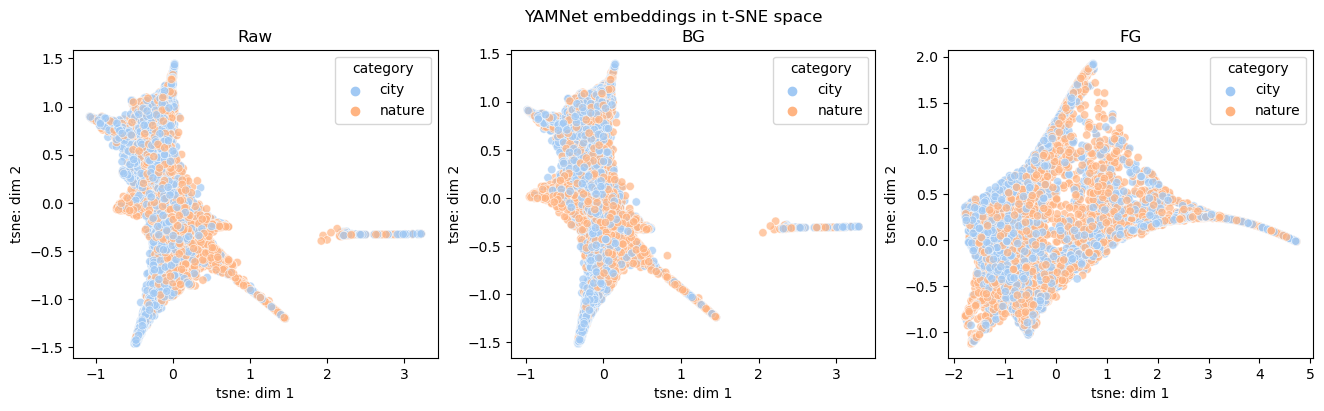

In [64]:
plot_multiple_tsne(embedding_raw_matrix, embedding_bg_matrix, embedding_fg_matrix, df_all['category'], 'YAMNet embeddings in t-SNE space')

In [ ]:
plot_multiple_tsne(vgg_raw_matrix, vgg_bg_matrix, vgg_fg_matrix, df_all['category'], 'VGGish embeddings in t-SNE space')

In [ ]:
plot_multiple_tsne(panns_embedding_raw, panns_embedding_bg, panns_embedding_fg, df_all['category'], 'PANNs embeddings in t-SNE space')

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13667 samples in 0.005s...
[t-SNE] Computed neighbors for 13667 samples in 2.829s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13667
[t-SNE] Computed conditional probabilities for sample 2000 / 13667
[t-SNE] Computed conditional probabilities for sample 3000 / 13667
[t-SNE] Computed conditional probabilities for sample 4000 / 13667
[t-SNE] Computed conditional probabilities for sample 5000 / 13667
[t-SNE] Computed conditional probabilities for sample 6000 / 13667
[t-SNE] Computed conditional probabilities for sample 7000 / 13667
[t-SNE] Computed conditional probabilities for sample 8000 / 13667
[t-SNE] Computed conditional probabilities for sample 9000 / 13667
[t-SNE] Computed conditional probabilities for sample 10000 / 13667
[t-SNE] Computed conditional probabilities for sample 11000 / 13667
[t-SNE] Computed conditional probabilities for sample 12000 / 13667
[t-SNE] Computed conditional probabilities for sa

/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_53808/939656521.py:10: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


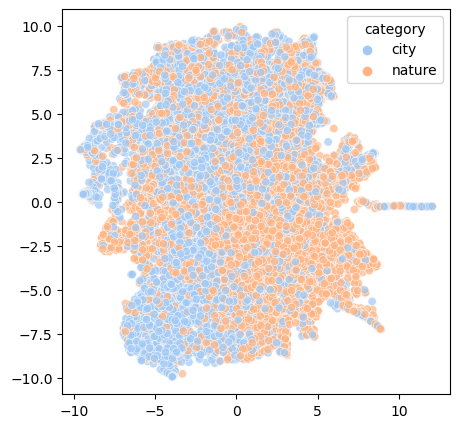

In [48]:
plot_tsne(embedding_raw_matrix, df_all['category'])

In [12]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(embedding_raw_matrix)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13667 samples in 0.006s...
[t-SNE] Computed neighbors for 13667 samples in 2.806s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13667
[t-SNE] Computed conditional probabilities for sample 2000 / 13667
[t-SNE] Computed conditional probabilities for sample 3000 / 13667
[t-SNE] Computed conditional probabilities for sample 4000 / 13667
[t-SNE] Computed conditional probabilities for sample 5000 / 13667
[t-SNE] Computed conditional probabilities for sample 6000 / 13667
[t-SNE] Computed conditional probabilities for sample 7000 / 13667
[t-SNE] Computed conditional probabilities for sample 8000 / 13667
[t-SNE] Computed conditional probabilities for sample 9000 / 13667
[t-SNE] Computed conditional probabilities for sample 10000 / 13667
[t-SNE] Computed conditional probabilities for sample 11000 / 13667
[t-SNE] Computed conditional probabilities for sample 12000 / 13667
[t-SNE] Computed conditional probabilities for sa

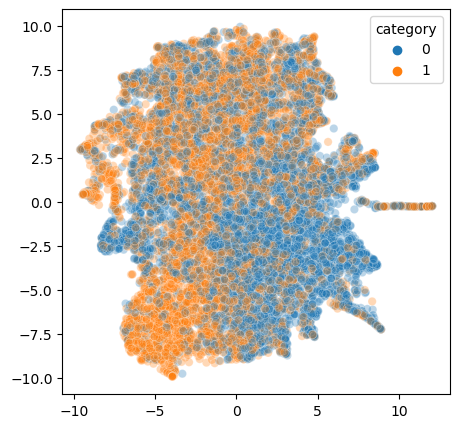

In [23]:
df = pd.DataFrame(embedding_raw_matrix)

df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(5,5))
sns.scatterplot(
    x=tsne_results[:,0], y=tsne_results[:,1],
    hue=df_all['category'],
#     palette=sns.color_palette("hls", 2),
#     data=embedding_raw_matrix,
    legend="full",
    alpha=0.3
)
plt.show()

In [18]:
df_all['category'].shape

(13667,)

In [41]:
a = mps_raw_matrix.reshape(-1,77,101)
a.shape

(13667, 77, 101)

In [45]:
b = np.mean(a, axis=0)
b.shape

(77, 101)

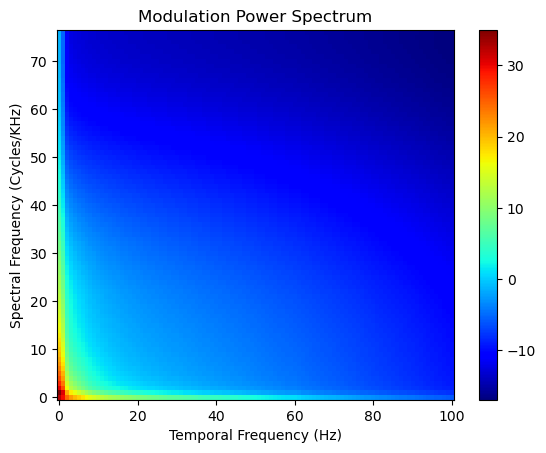

In [48]:
DBNOISE=100
plt.figure()
plt.clf()
cmap = plt.get_cmap('jet')
# ex = (0, 100, myBioSound.wf.min()*1e3, myBioSound.wf.max()*1e3)
# logMPS = 10.0*np.log10(myBioSound.mps)
# maxMPS = logMPS.max()
# minMPS = maxMPS-DBNOISE
# logMPS[logMPS < minMPS] = minMPS
#         ex = (wt.min(), 100, wf.min()*1e3, wf.max()*1e3)
#         logMPS = 10.0*np.log10(mps)
#         maxMPS = logMPS.max()
#         minMPS = maxMPS-DBNOISE
#         logMPS[logMPS < minMPS] = minMPS
# plt.imshow(logMPS, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
plt.imshow(np.log10(b)*10, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap)
plt.ylabel('Spectral Frequency (Cycles/KHz)')
plt.xlabel('Temporal Frequency (Hz)')
plt.colorbar()
# plt.ylim((0,myBioSound.wf.max()*1e3))
plt.title('Modulation Power Spectrum')
plt.show()

In [2]:
nature_pklfile_list = glob.glob('../data/interim/GoogleAudioSet_unbalanced_list/Outside, rural or natural/*.pkl')
city_pklfile_list = glob.glob('../data/interim/GoogleAudioSet_unbalanced_list/Outside, urban or manmade/*.pkl')


In [3]:
df_nature = pd.read_csv('../data/interim/GoogleAudioSet_unbalanced_list/nature_no_music.csv', index_col=0)
df_city = pd.read_csv('../data/interim/GoogleAudioSet_unbalanced_list/city_no_music.csv', index_col=0)

In [4]:
nature_noMusic_file_list = '../data/interim/GoogleAudioSet_unbalanced_list/Outside, rural or natural/'+df_nature['filename']+'.0.pkl'
city_noMusic_file_list = '../data/interim/GoogleAudioSet_unbalanced_list/Outside, urban or manmade/'+df_city['filename']+'.0.pkl'

In [5]:
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
nature_file_list = intersection(nature_pklfile_list, nature_noMusic_file_list)
city_file_list = intersection(city_pklfile_list, city_noMusic_file_list)

In [6]:
import pickle
import pandas as pd
import numpy as np

df_indices_all = []
df_indices_bg = []
df_indices_fg = []
mps_all = []
mps_bg = []
mps_fg = []
for filename in nature_file_list:
    # open a file, where you stored the pickled data
    file = open(filename, 'rb')

    # dump information to that file
    output = pickle.load(file)
    df_indices_all.append(output['df_indices'])
    df_indices_bg.append(output['df_indices_bg'])
    df_indices_fg.append(output['df_indices_fg'])
    mps_all.append(output['mps'])
    mps_fg.append(output['mps_fg'])
    mps_bg.append(output['mps_bg'])

    # close the file
    file.close()
df_indices_nature = pd.concat(df_indices_all)
df_indices_bg_nature = pd.concat(df_indices_bg)
df_indices_fg_nature = pd.concat(df_indices_fg)
mps_nature = np.stack(mps_all, axis=2)
mps_bg_nature = np.stack(mps_bg, axis=2)
mps_fg_nature = np.stack(mps_fg, axis=2)


df_indices_all = []
df_indices_bg = []
df_indices_fg = []
mps_all = []
mps_bg = []
mps_fg = []
for filename in city_file_list:
    # open a file, where you stored the pickled data
    file = open(filename, 'rb')

    # dump information to that file
    output = pickle.load(file)
    df_indices_all.append(output['df_indices'])
    df_indices_bg.append(output['df_indices_bg'])
    df_indices_fg.append(output['df_indices_fg'])
    mps_all.append(output['mps'])
    mps_fg.append(output['mps_fg'])
    mps_bg.append(output['mps_bg'])

    # close the file
    file.close()
df_indices_city = pd.concat(df_indices_all)
df_indices_bg_city = pd.concat(df_indices_bg)
df_indices_fg_city = pd.concat(df_indices_fg)
mps_city = np.stack(mps_all, axis=2)
mps_bg_city = np.stack(mps_bg, axis=2)
mps_fg_city= np.stack(mps_fg, axis=2)

In [7]:
from scipy.stats import ttest_ind, mannwhitneyu
statistic_all, pvalue_all = ttest_ind(df_indices_nature, df_indices_city, nan_policy='omit', equal_var=False)
statistic_bg, pvalue_bg = ttest_ind(df_indices_bg_nature, df_indices_bg_city, nan_policy='omit', equal_var=False)
statistic_fg, pvalue_fg = ttest_ind(df_indices_fg_nature, df_indices_fg_city, nan_policy='omit', equal_var=False)

statistic_mw_all, pvalue_mw_all = mannwhitneyu(df_indices_nature, df_indices_city, nan_policy='omit')
statistic_mw_bg, pvalue_mw_bg = mannwhitneyu(df_indices_bg_nature, df_indices_bg_city, nan_policy='omit')
statistic_mw_fg, pvalue_mw_fg = mannwhitneyu(df_indices_fg_nature, df_indices_fg_city, nan_policy='omit')


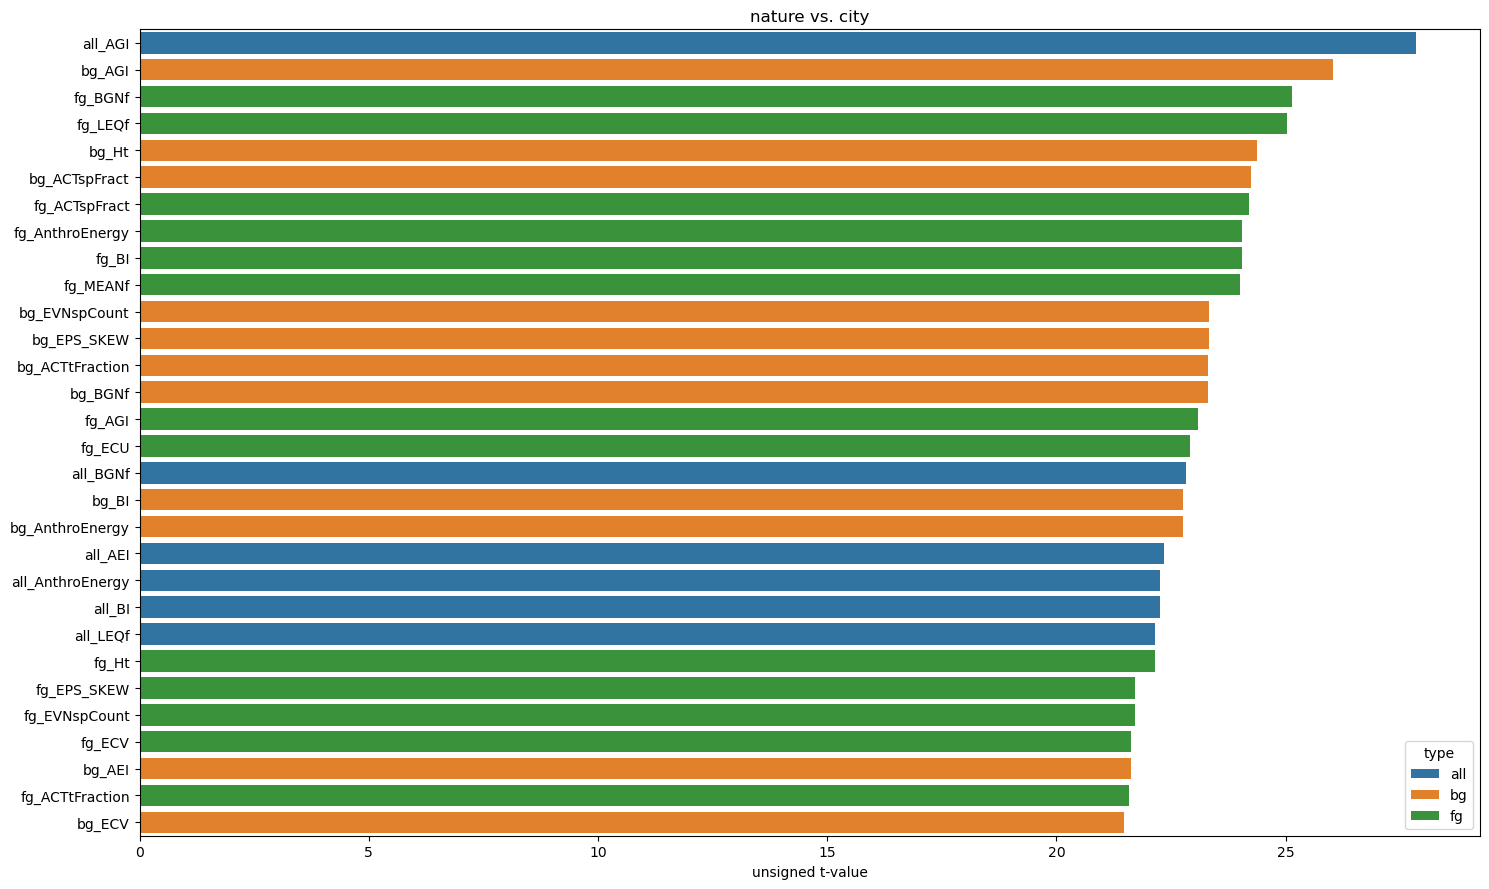

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

tval_df = pd.DataFrame(index = ('all_'+df_indices_nature.columns).union('bg_'+df_indices_bg_nature.columns).union('fg_'+df_indices_fg_nature.columns), 
                       data = np.abs(list(statistic_all.data)+list(statistic_bg.data)+list(statistic_fg.data)),
                       columns = ['stats'])
tval_df['type'] = [i.split('_', 1)[0] for i in tval_df.index]

tval_df.sort_values(by=['stats'], ascending=False, inplace = True)
sel_range = 30
tval_df = tval_df.iloc[:sel_range]

fig, ax = plt.subplots(figsize=(15,9)) 

graph = sns.barplot(y=list(tval_df.index), x=tval_df['stats'], ax=ax, orient = 'h', hue=tval_df['type'], dodge = False)
ax.set_xlabel('unsigned t-value')
plt.title('nature vs. city')
plt.tight_layout()
plt.show()

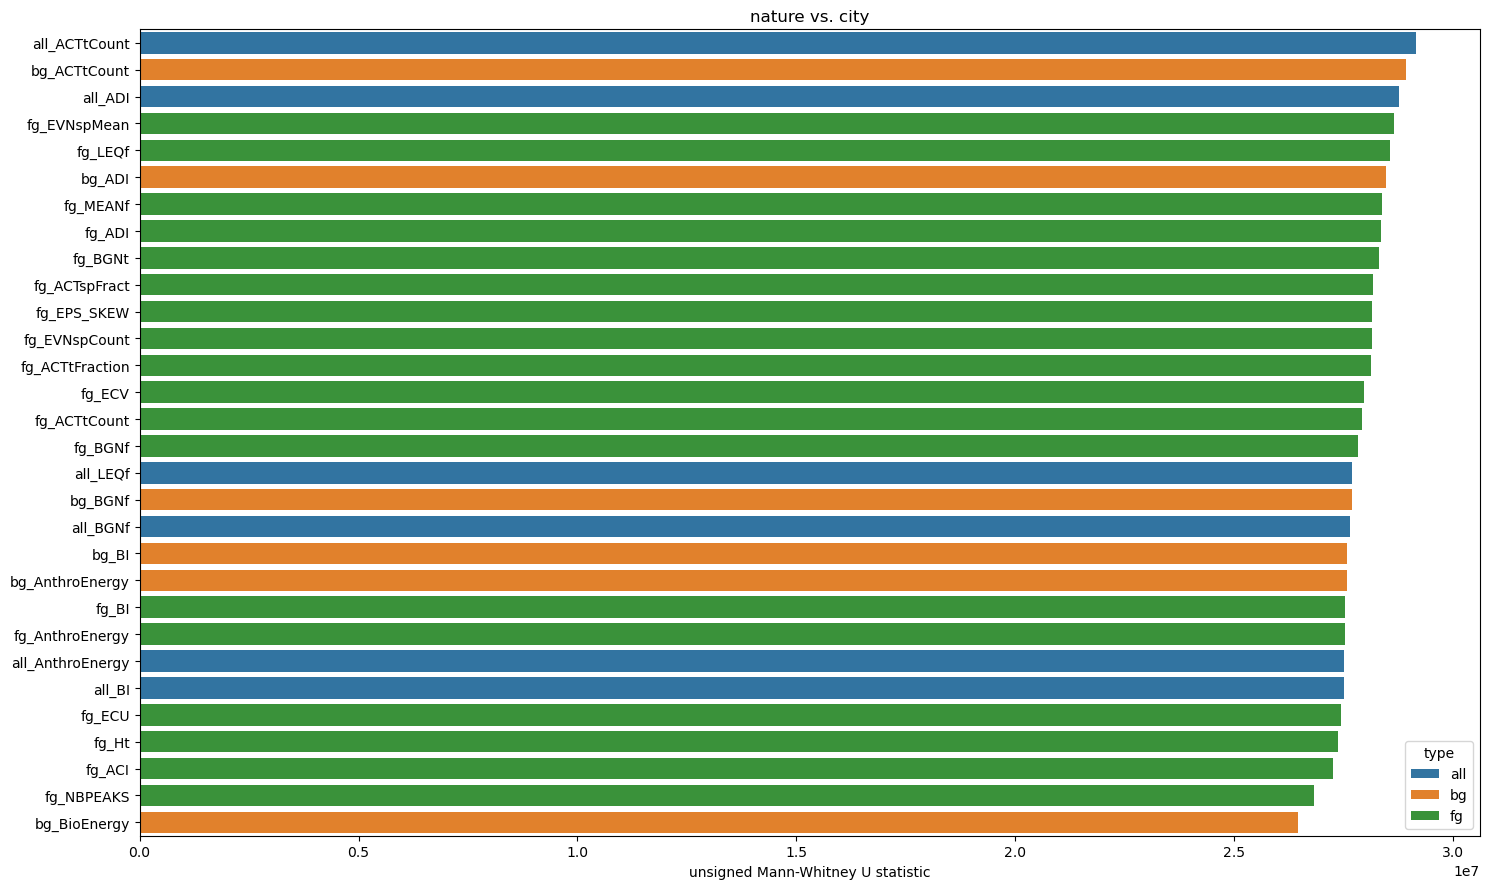

In [9]:
mwval_df = pd.DataFrame(index = ('all_'+df_indices_nature.columns).union('bg_'+df_indices_bg_nature.columns).union('fg_'+df_indices_fg_nature.columns), 
                       data = np.abs(list(statistic_mw_all.data)+list(statistic_mw_bg.data)+list(statistic_mw_fg.data)),
                       columns = ['stats'])
mwval_df['type'] = [i.split('_', 1)[0] for i in mwval_df.index]

mwval_df.sort_values(by=['stats'], ascending=False, inplace = True)
sel_range = 30
mwval_df = mwval_df.iloc[:sel_range]

fig, ax = plt.subplots(figsize=(15,9)) 

graph = sns.barplot(y=list(mwval_df.index), x=mwval_df['stats'], ax=ax, orient = 'h', hue=mwval_df['type'], dodge = False)
ax.set_xlabel('unsigned Mann-Whitney U statistic')
plt.title('nature vs. city')
plt.tight_layout()
plt.show()

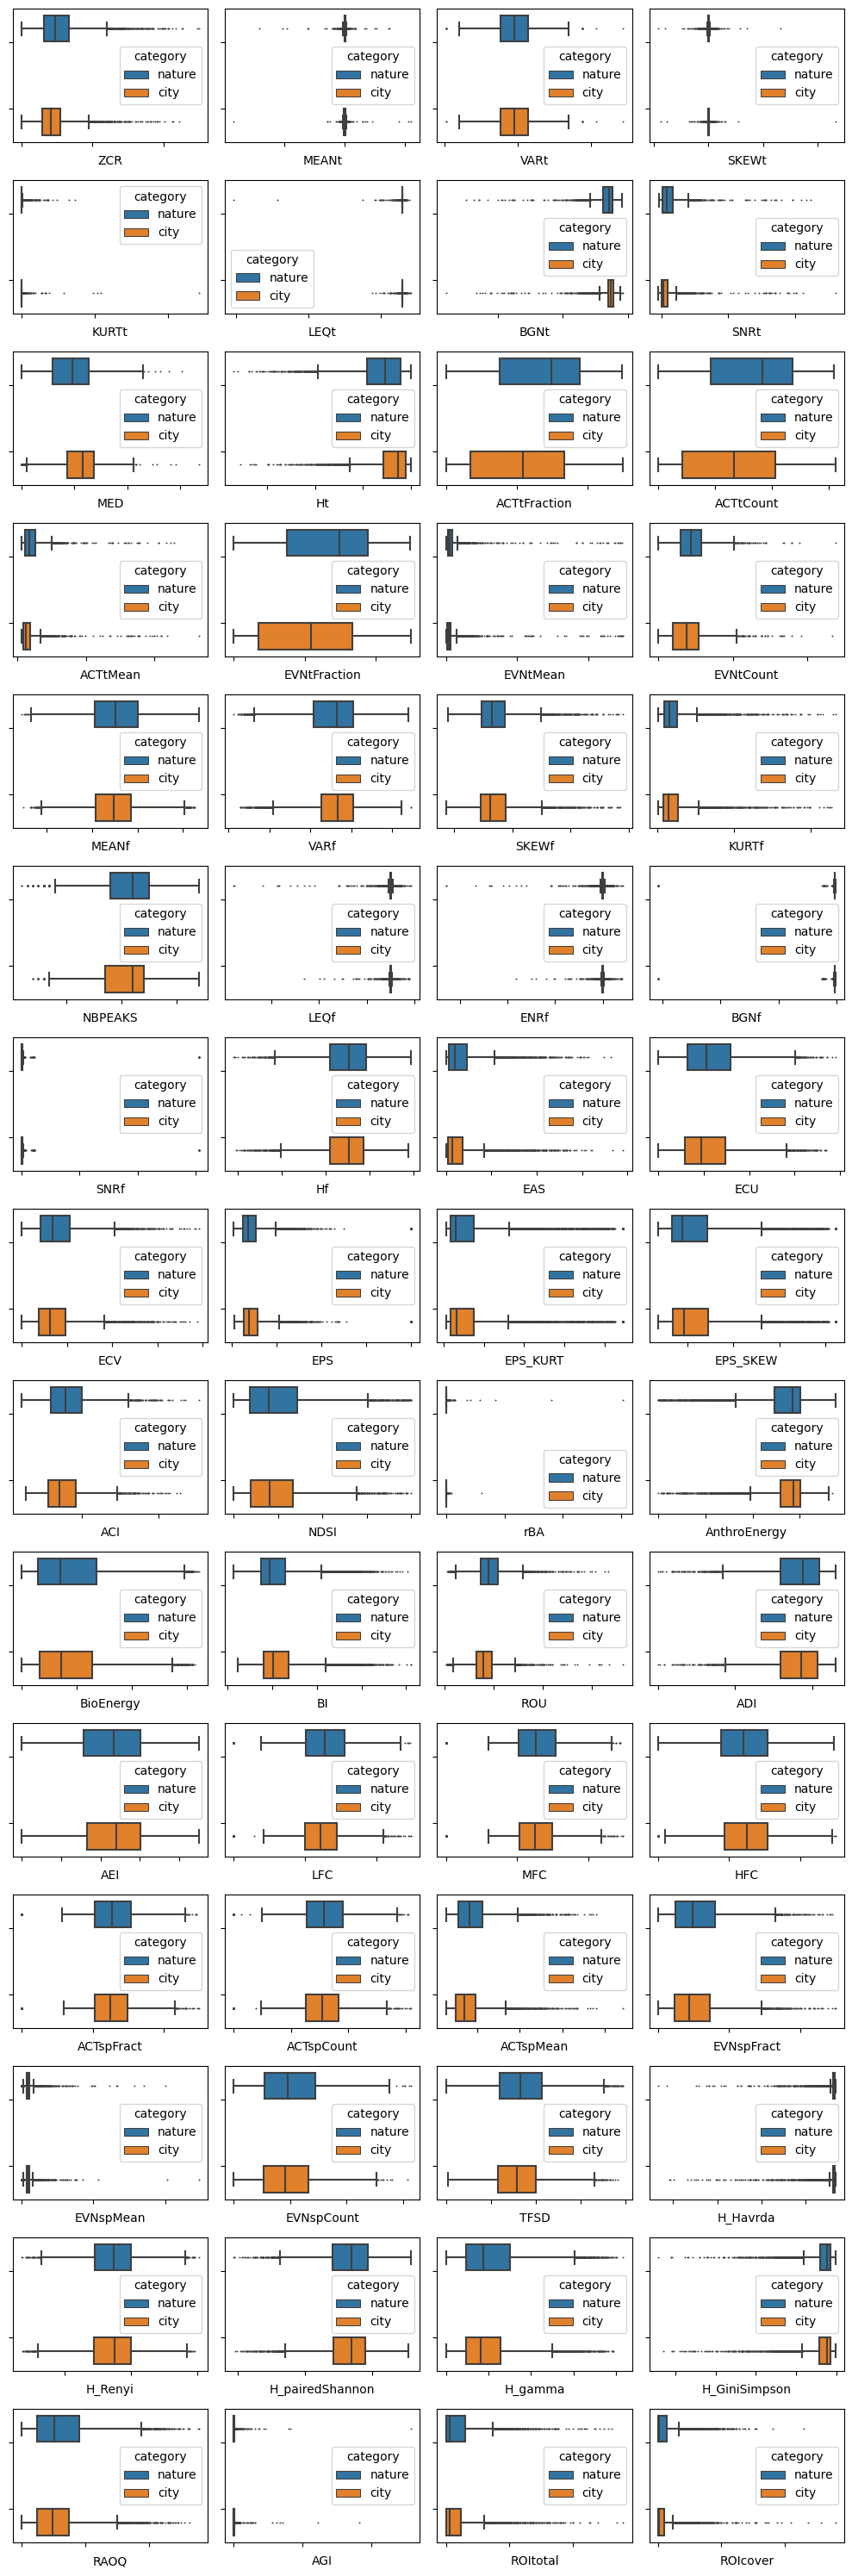

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

nature_source_list = ['nature_'+i.rsplit('/', 2)[1] for i in nature_file_list]
city_source_list = ['city_'+i.rsplit('/', -1)[3] for i in city_file_list]

df_indices_nature['source'] = nature_source_list
df_indices_nature['category'] = 'nature'
df_indices_city['source'] = city_source_list
df_indices_city['category'] = 'city'
df_indices_all = pd.concat([df_indices_nature, df_indices_city])

fig, ax = plt.subplots(15,4, figsize=(10,30))
for n in range(len(df_indices_all.columns)-2):
    n1 = int(np.floor(n/4))
    n2 = n%4
    sns.boxplot(y='source', x=df_indices_all.columns[n], hue='category', data=df_indices_all, ax = ax[n1,n2], fliersize = 0.5)
    ax[n1,n2].set(ylabel=None)
    ax[n1,n2].set(xticklabels=[])
    ax[n1,n2].set(yticklabels=[])
    plt.tight_layout()



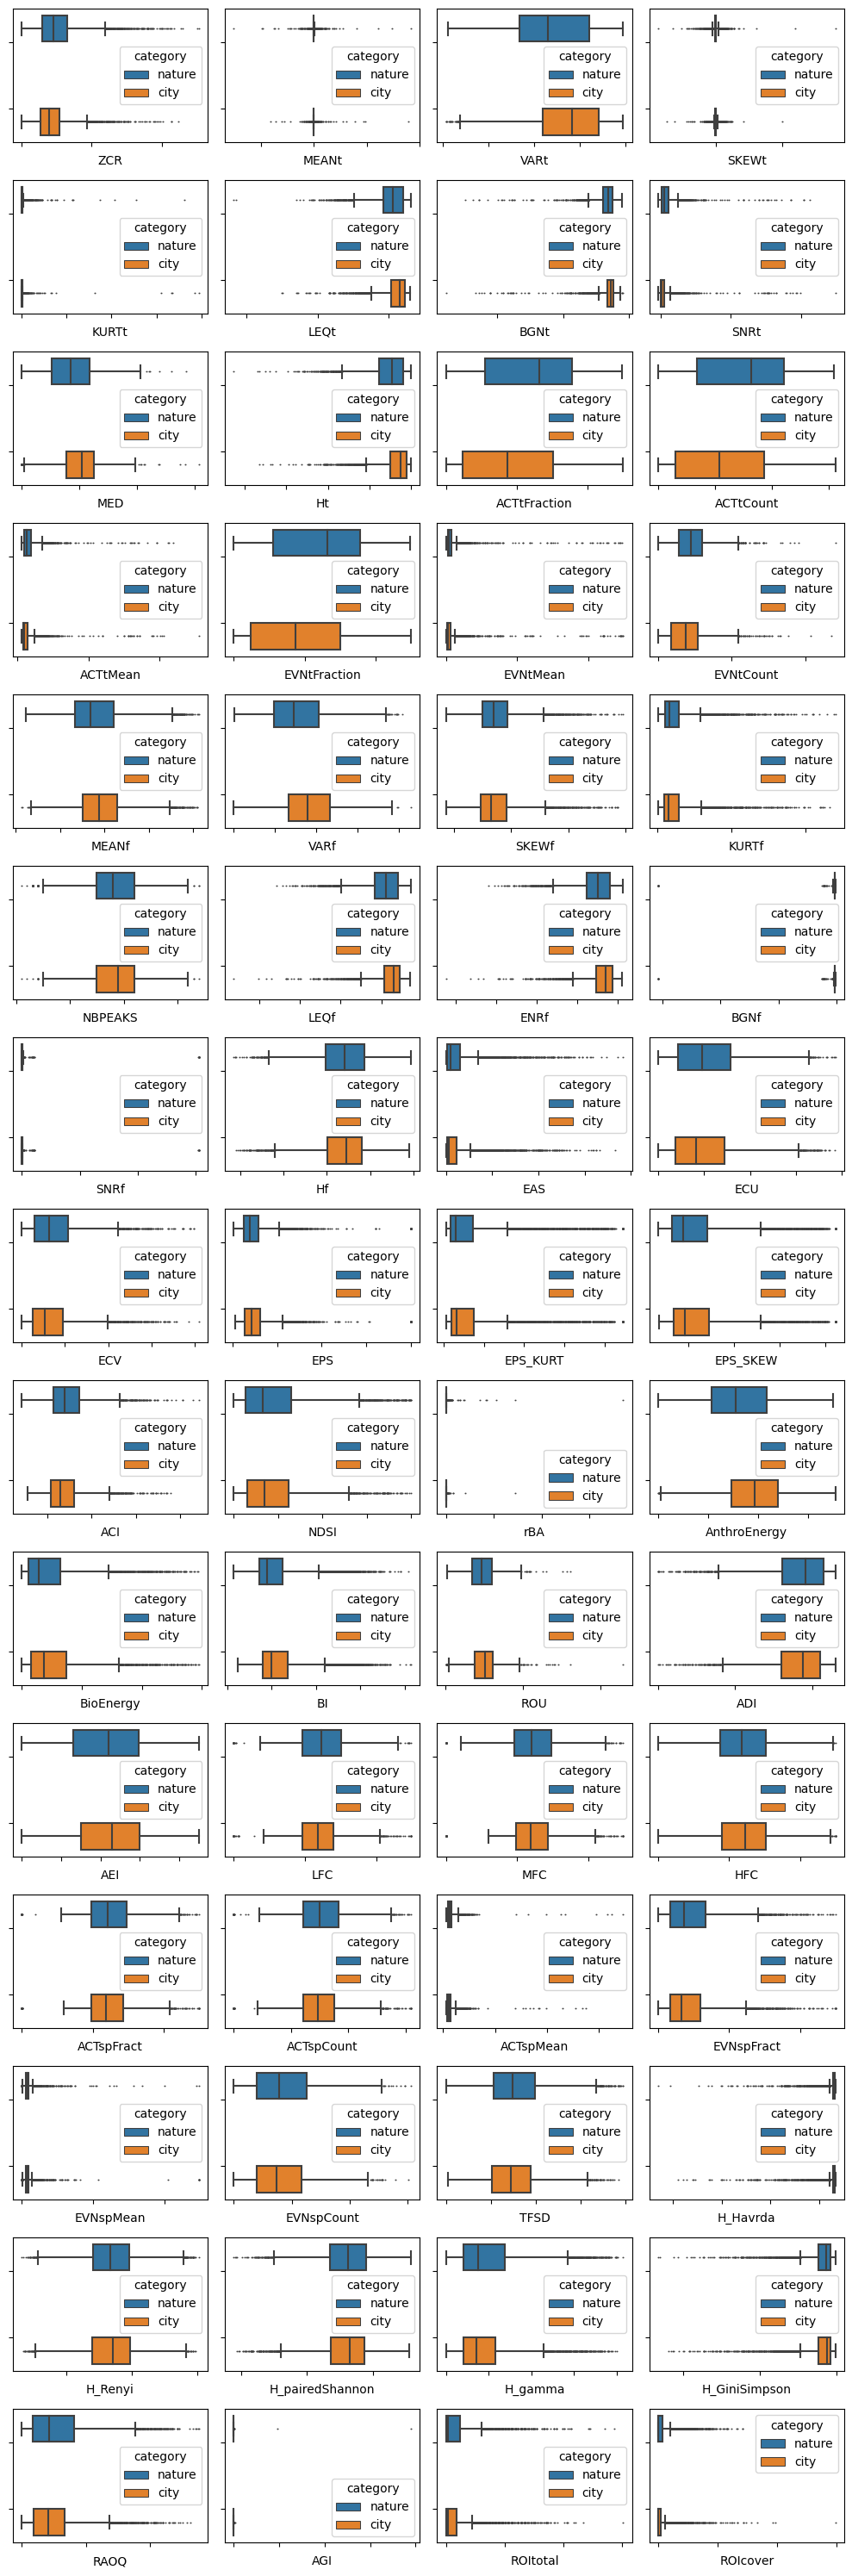

In [11]:
nature_source_list = ['nature_'+i.rsplit('/', 2)[1] for i in nature_file_list]
city_source_list = ['city_'+i.rsplit('/', -1)[3] for i in city_file_list]

df_indices_bg_nature['source'] = nature_source_list
df_indices_bg_nature['category'] = 'nature'
df_indices_bg_city['source'] = city_source_list
df_indices_bg_city['category'] = 'city'
df_indices_bg_all = pd.concat([df_indices_bg_nature, df_indices_bg_city])

fig, ax = plt.subplots(15,4, figsize=(10,30))
for n in range(len(df_indices_bg_all.columns)-2):
    n1 = int(np.floor(n/4))
    n2 = n%4
    sns.boxplot(y='source', x=df_indices_bg_all.columns[n], hue='category', data=df_indices_bg_all, ax = ax[n1,n2], fliersize = 0.5)
#     ax[n1,n2].set(xlabel=None)
    ax[n1,n2].set(ylabel=None)
    ax[n1,n2].set(xticklabels=[])
    ax[n1,n2].set(yticklabels=[])
    plt.tight_layout()

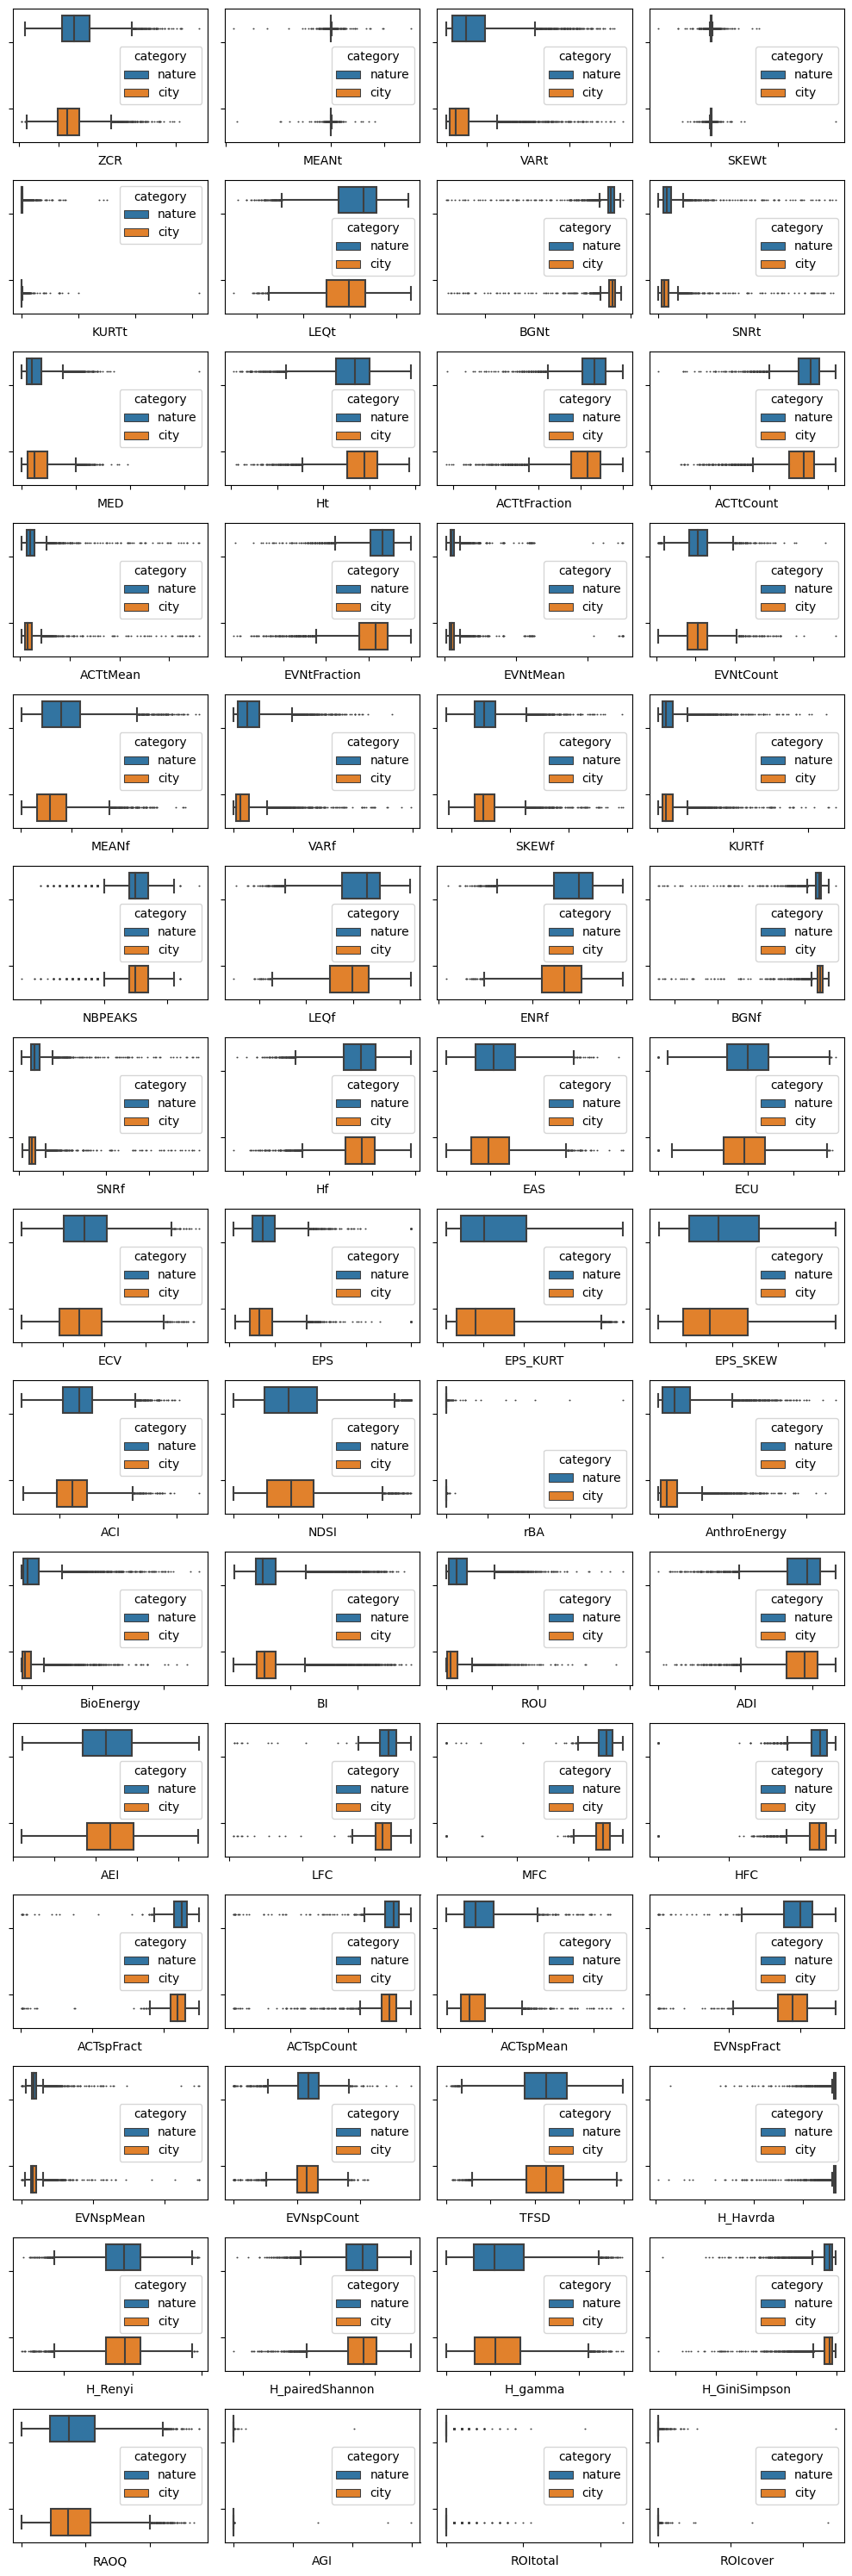

In [12]:
df_indices_fg_nature['source'] = nature_source_list
df_indices_fg_nature['category'] = 'nature'
df_indices_fg_city['source'] = city_source_list
df_indices_fg_city['category'] = 'city'
df_indices_fg_all = pd.concat([df_indices_fg_nature, df_indices_fg_city])

fig, ax = plt.subplots(15,4, figsize=(10,30))
for n in range(len(df_indices_fg_all.columns)-2):
    n1 = int(np.floor(n/4))
    n2 = n%4
    sns.boxplot(y='source', x=df_indices_fg_all.columns[n], hue='category', data=df_indices_fg_all, ax = ax[n1,n2], fliersize = 0.5)
#     ax[n1,n2].set(xlabel=None)
    ax[n1,n2].set(ylabel=None)
    ax[n1,n2].set(xticklabels=[])
    ax[n1,n2].set(yticklabels=[])
    plt.tight_layout()

In [13]:
statistic_all, pvalue_all = ttest_ind(mps_nature, mps_city, nan_policy='omit', equal_var=False, axis=2)
statistic_bg, pvalue_bg = ttest_ind(mps_bg_nature, mps_bg_city, nan_policy='omit', equal_var=False, axis=2)
statistic_fg, pvalue_fg = ttest_ind(mps_fg_nature, mps_fg_city, nan_policy='omit', equal_var=False, axis=2)


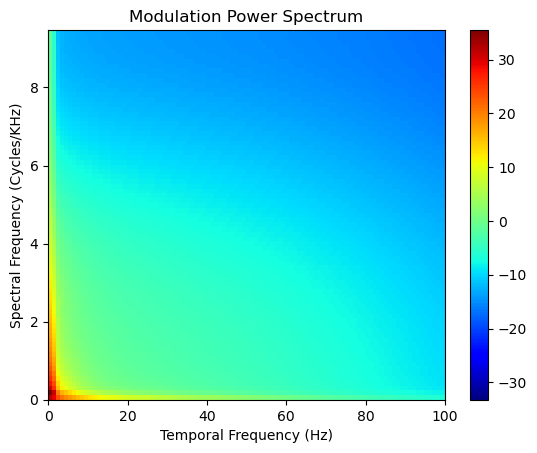

In [14]:
plt.figure()
plt.clf()
DBNOISE = 50
cmap = plt.get_cmap('jet')
ex = (output['wt'].min(), output['wt'].max(), output['wf'].min()*1e3, output['wf'].max()*1e3)
logMPS = 10.0*np.log10(mps_city.mean(2))
maxMPS = logMPS.max()
minMPS = maxMPS-DBNOISE
minMPS = logMPS.min()
logMPS[logMPS < minMPS] = minMPS
plt.imshow(logMPS, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
plt.ylabel('Spectral Frequency (Cycles/KHz)')
plt.xlabel('Temporal Frequency (Hz)')
plt.colorbar()
plt.ylim((0,output['wf'].max()*1e3))
plt.xlim((0,100))
plt.title('Modulation Power Spectrum')
plt.show()

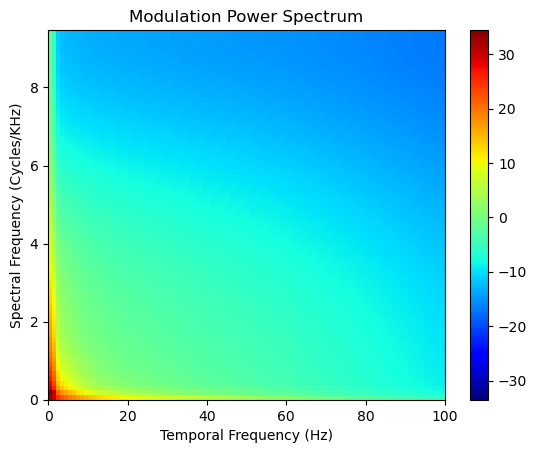

In [15]:
plt.figure()
plt.clf()
DBNOISE = 50
cmap = plt.get_cmap('jet')
ex = (output['wt'].min(), output['wt'].max(), output['wf'].min()*1e3, output['wf'].max()*1e3)
logMPS = 10.0*np.log10(mps_nature.mean(2))
maxMPS = logMPS.max()
minMPS = maxMPS-DBNOISE
minMPS = logMPS.min()
logMPS[logMPS < minMPS] = minMPS
plt.imshow(logMPS, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
plt.ylabel('Spectral Frequency (Cycles/KHz)')
plt.xlabel('Temporal Frequency (Hz)')
plt.colorbar()
plt.ylim((0,output['wf'].max()*1e3))
plt.xlim((0,100))
plt.title('Modulation Power Spectrum')
plt.show()

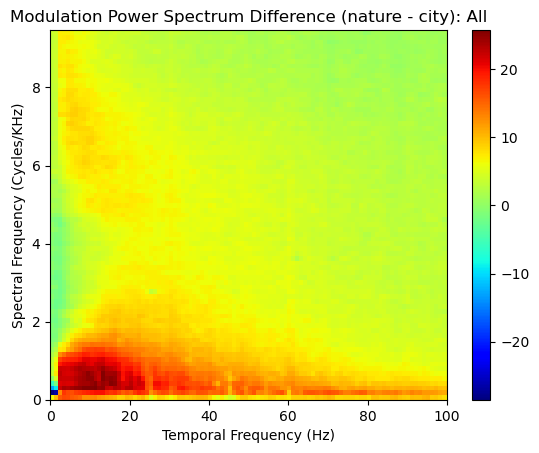

In [16]:
cmap = plt.get_cmap('jet')
ex = (output['wt'].min(), output['wt'].max(), output['wf'].min()*1e3, output['wf'].max()*1e3)
plt.imshow(statistic_all, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
plt.ylabel('Spectral Frequency (Cycles/KHz)')
plt.xlabel('Temporal Frequency (Hz)')
plt.colorbar()
plt.ylim((0,output['wf'].max()*1e3))
plt.xlim((0,100))
plt.title('Modulation Power Spectrum Difference (nature - city): All')
plt.show()

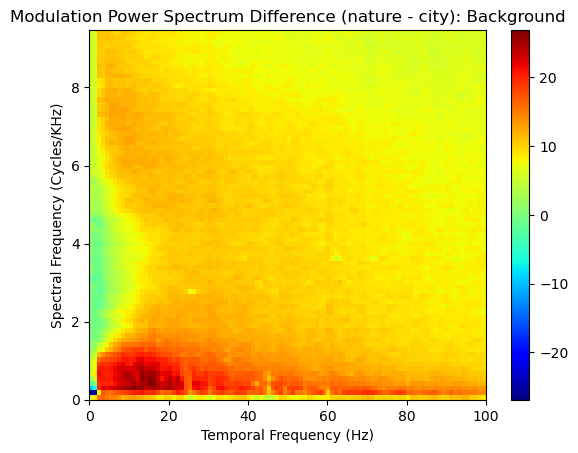

In [17]:
cmap = plt.get_cmap('jet')
ex = (output['wt'].min(), output['wt'].max(), output['wf'].min()*1e3, output['wf'].max()*1e3)
plt.imshow(statistic_bg, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
plt.ylabel('Spectral Frequency (Cycles/KHz)')
plt.xlabel('Temporal Frequency (Hz)')
plt.colorbar()
plt.ylim((0,output['wf'].max()*1e3))
plt.xlim((0,100))
plt.title('Modulation Power Spectrum Difference (nature - city): Background')
plt.show()

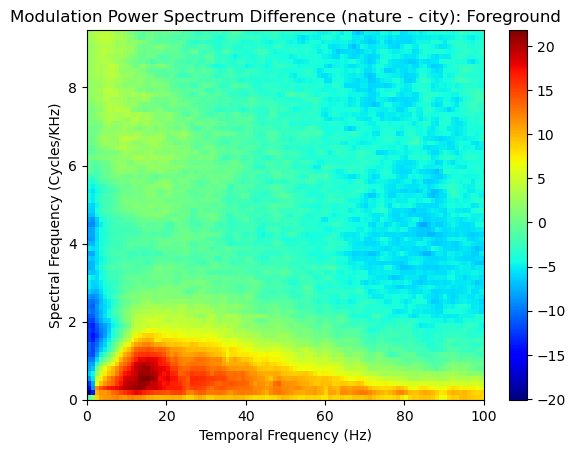

In [18]:
cmap = plt.get_cmap('jet')
ex = (output['wt'].min(), output['wt'].max(), output['wf'].min()*1e3, output['wf'].max()*1e3)
plt.imshow(statistic_fg, interpolation='nearest', aspect='auto', origin='lower', cmap=cmap, extent=ex)
plt.ylabel('Spectral Frequency (Cycles/KHz)')
plt.xlabel('Temporal Frequency (Hz)')
plt.colorbar()
plt.ylim((0,output['wf'].max()*1e3))
plt.xlim((0,100))
plt.title('Modulation Power Spectrum Difference (nature - city): Foreground')
plt.show()

# Correlations

In [19]:
df_all = pd.concat([df_indices_city,df_indices_nature], ignore_index = True)

/var/folders/fw/slnm06yn15lgwlcg_7jpt3t00000gn/T/ipykernel_91751/3095959285.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_all.corr(), linewidth = 0.5 , cmap = 'coolwarm', vmin=-1, vmax=1, fmt=".2f", ax = ax)


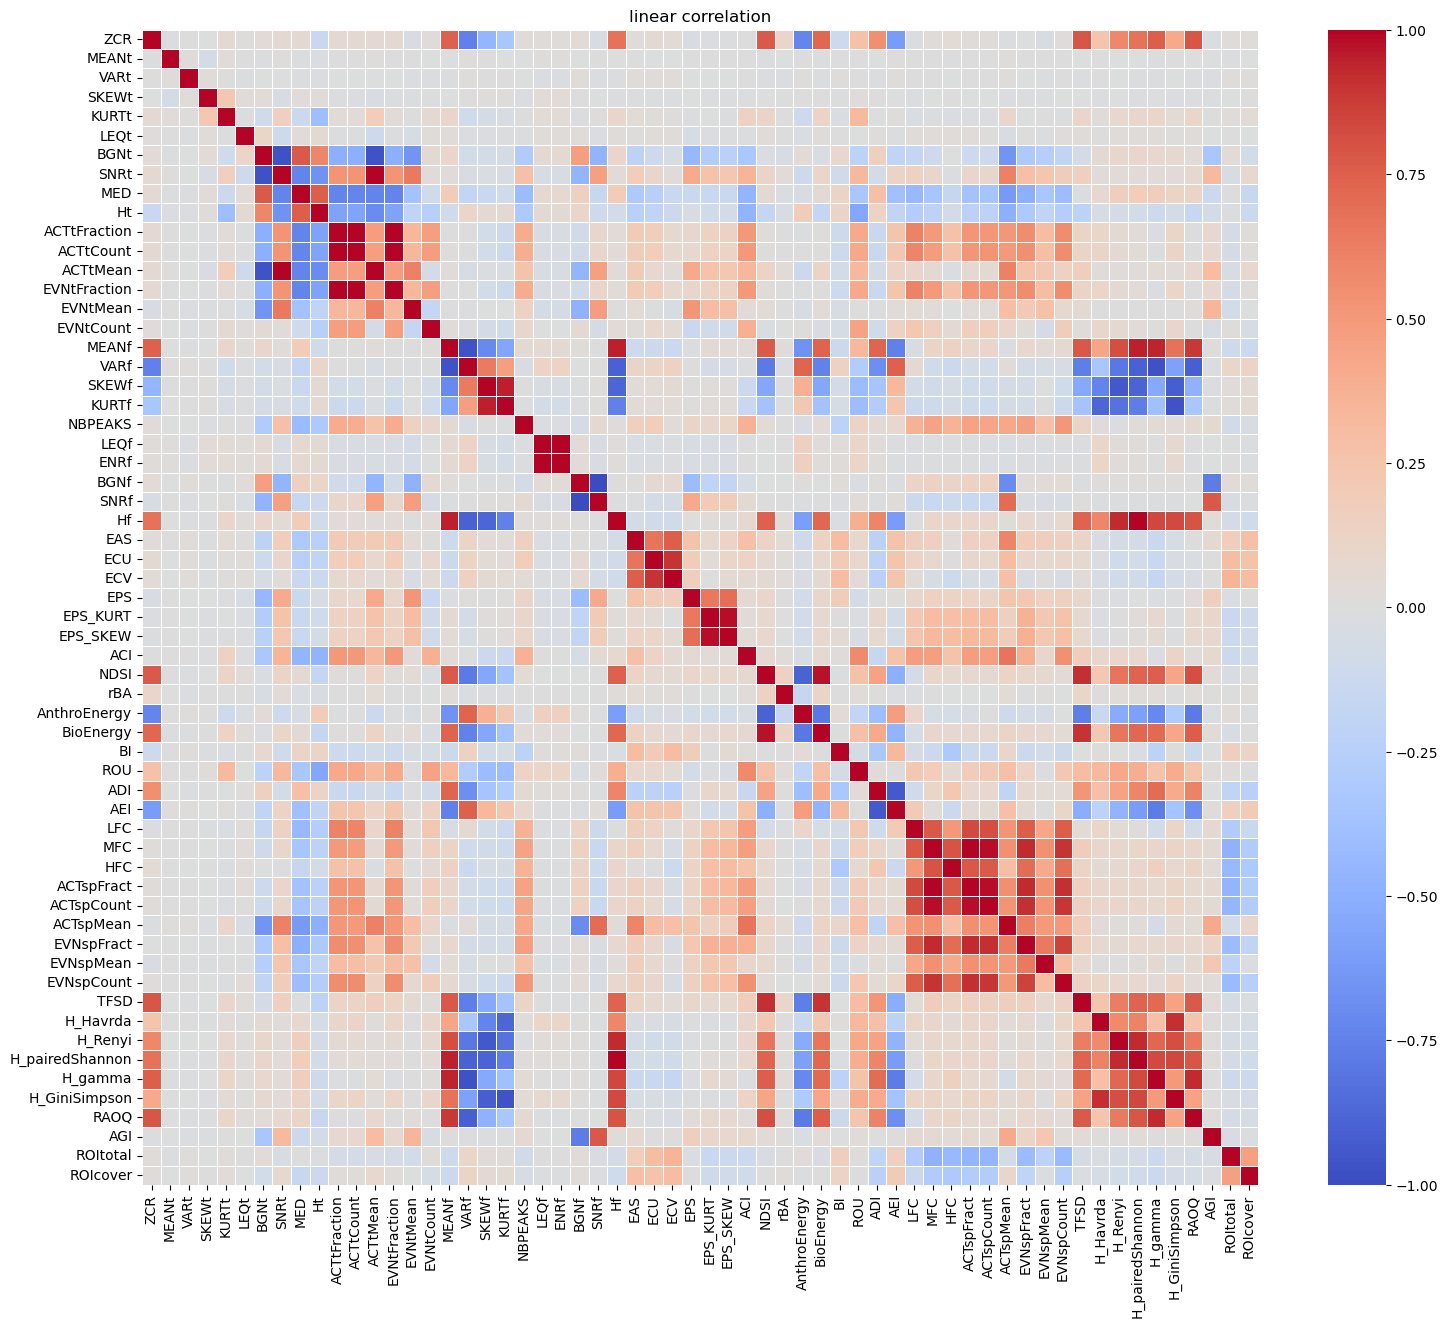

In [22]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(18,15)) 
sns.heatmap(df_all.corr(), linewidth = 0.5 , cmap = 'coolwarm', vmin=-1, vmax=1, fmt=".2f", ax = ax)
plt.title('linear correlation')
plt.show()